In [1]:
### Importando as bibliotecas e realizando conexão com o banco
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np
import seaborn as sns
from datetime import date
conn = pg.connect(database="gc",user="postgres", password="1234")

In [2]:
### Atribuindo os dados das tabelas em DataFrames
mt = psql.read_sql('SELECT * FROM "matchmaking_stats_summary"', conn)
pm = psql.read_sql('SELECT * FROM "player_monthly_stats"', conn)
pl = psql.read_sql('SELECT * FROM "players"', conn)

3


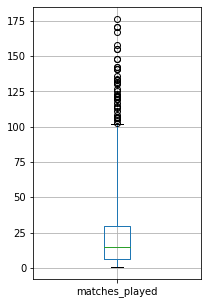

In [3]:
### Criando colunas e avaliando outliers
matches_played = pm['wins']+pm['loss']
pm['matches_played'] = matches_played
pm[['matches_played']].boxplot(whis=3, figsize=(3,5))
pm_actives = pm[pm['matches_played'] < 100]
pm_actives = pm_actives[pm_actives['matches_played'] >= 3].copy()
print(pm_actives['matches_played'].min())

In [4]:
### Criando colunas
saldo_pontos = pm_actives['wins']-pm_actives['loss']
pm_actives['saldo_pontos'] = saldo_pontos
percent_hs = pm_actives['headshots']/pm_actives['kills']*100
pm_actives['percent_hs'] = percent_hs

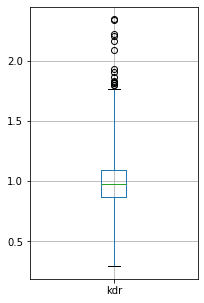

In [6]:
### Criando coluna KDR e encontrando outliers
kdr = pm_actives['kills']/pm_actives['deaths']
pm_actives['kdr'] = kdr
pm_actives['kdr'] = pm_actives['kdr'].replace(np.inf,0)
pm_actives[['kdr']].boxplot(whis=3, figsize=(3,5))
pm_actives = pm_actives[pm_actives['kdr'] < 1.75]

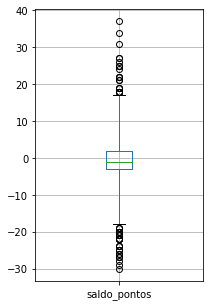

In [7]:
### Encontrando outliers e retirando-os
pm_actives[['saldo_pontos']].boxplot(whis=3, figsize=(3,5))
pm_actives = pm_actives[pm_actives['saldo_pontos'] < 18]
pm_actives = pm_actives[pm_actives['saldo_pontos'] > -18]

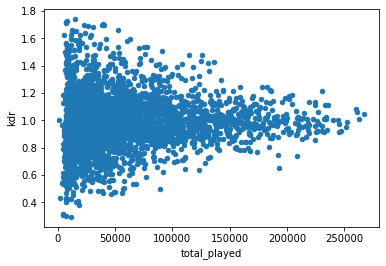

In [8]:
### Grafico de total de tempo jogado por kdr
pm_actives.plot.scatter(x='total_played',y='kdr')

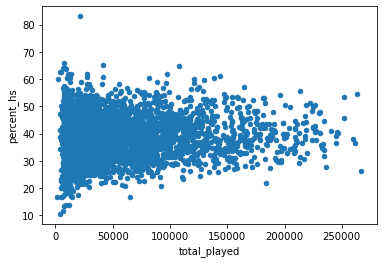

In [9]:
### Grafico de total de tempo jogado por percentual de hs
pm_actives.plot.scatter(x='total_played',y='percent_hs')

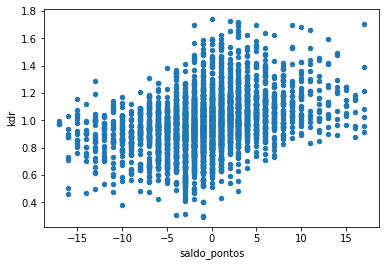

In [10]:
### Grafico de saldo de pontos por kdr
pm_actives.plot.scatter(x='saldo_pontos',y='kdr')

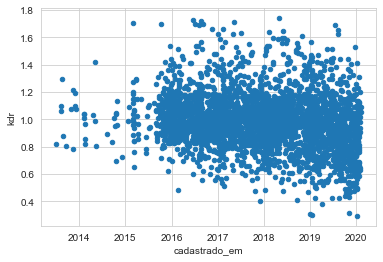

In [31]:
### Grafico de data de cadastro por kdr
actives_reg_date = pd.merge(pm_actives, pl, on='player_id')
actives_reg_date.plot.scatter(x='cadastrado_em', y='kdr')
ax = plot.gca()
ax.invert_xaxis()

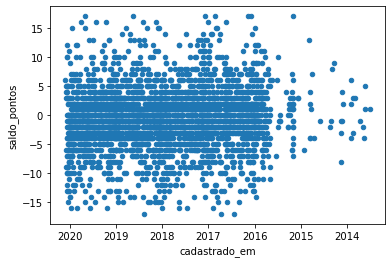

In [12]:
### Grafico de data de cadastro por saldo de pontos
actives_reg_date = pd.merge(pm_actives, pl, on='player_id')
actives_reg_date.plot.scatter(x='cadastrado_em', y='saldo_pontos')
ax = plot.gca()
ax.invert_xaxis()

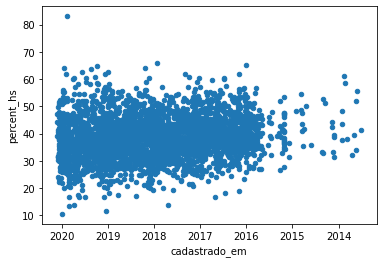

In [13]:
### Grafico de data de cadastro por percentual hs
actives_reg_date = pd.merge(pm_actives, pl, on='player_id')
actives_reg_date.plot.scatter(x='cadastrado_em', y='percent_hs')
ax = plot.gca()
ax.invert_xaxis()

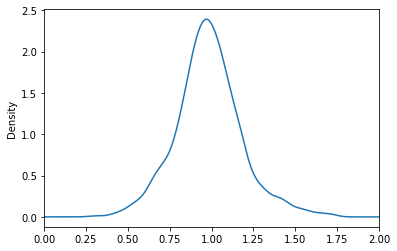

In [14]:
### Grafico da media de kdr
pm_actives['kdr'].plot.kde(xlim=(0,2))

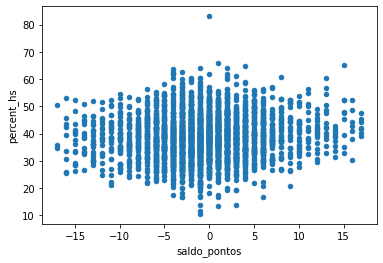

In [15]:
### Grafico de saldo de pontos por percentual hs
pm_actives.plot.scatter(x='saldo_pontos',y='percent_hs')

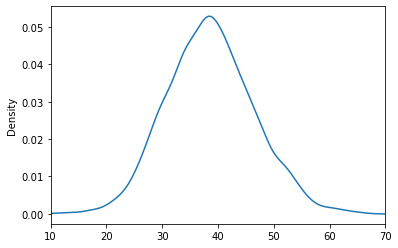

In [16]:
### Grafico de media de percentual hs
pm_actives['percent_hs'].plot.kde(xlim=(10,70))

22.443178220956


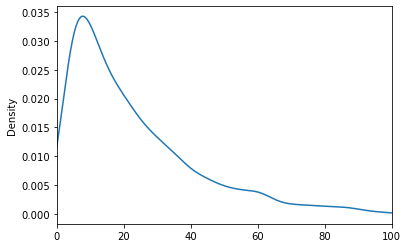

In [17]:
### Grafico procentual da media de partidas jogadas
pm_actives['matches_played'].plot.kde(xlim=(0,100))
print(pm_actives['matches_played'].mean())

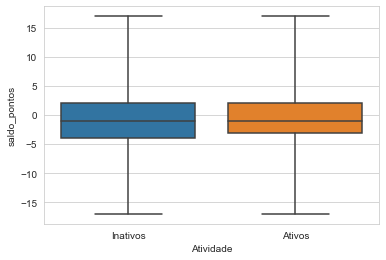

In [18]:
### Descobrindo players que jogaram mês passado e nao estao ativos, ou seja, nao jogaram este mes
inativos_mes = pm_actives[~pm_actives['player_id'].isin(mt['player_id'])]
ativos_mes = pm_actives[pm_actives['player_id'].isin(mt['player_id'])]

### Grafico de players ativos e inativos por saldo de pontos
sns.set_style("whitegrid")
con = pd.concat([inativos_mes[['saldo_pontos']].assign(Atividade='Inativos'), ativos_mes[['saldo_pontos']].assign(Atividade='Ativos')])
ax = sns.boxplot(x='Atividade', y='saldo_pontos', data=con, whis=3)
plot.show()

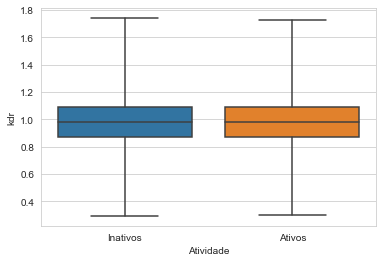

In [19]:
### Grafico de players ativos e inativos por kdr
con = pd.concat([inativos_mes[['kdr']].assign(Atividade='Inativos'), ativos_mes[['kdr']].assign(Atividade='Ativos')])
ax = sns.boxplot(x='Atividade', y='kdr', data=con, whis=3)
plot.show()

In [20]:
### Percentual de jogadores ativos e inativos, relacionado com os que pinam e os que não pinam
ativos_mes = pm_actives[pm_actives['player_id'].isin(mt['player_id'])]
pinadores_inativos = inativos_mes[inativos_mes['kdr'] < 1]
percent_pinadores = pinadores_inativos.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0]) 
print(percent_pinadores)

pinadores_ativos = ativos_mes[ativos_mes['kdr'] < 1]
percent_pinadores_at = pinadores_ativos.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0]) 
print(percent_pinadores_at)

bons_inativos = inativos_mes[inativos_mes['kdr'] >= 1]
percent_bons = bons_inativos.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0]) 
print(percent_bons)

bons_ativos = ativos_mes[ativos_mes['kdr'] >= 1]
percent_bons_at = bons_ativos.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0]) 
print(percent_bons_at)

0.2595758151313707
0.2928141817030706
0.2127255460588794
0.23488445710667932


Text(0, 0.5, 'Porcentagem')

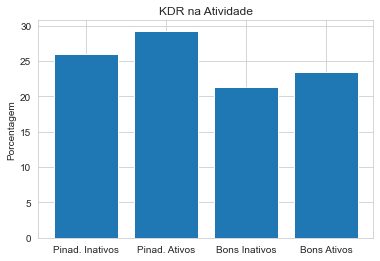

In [21]:
### Grafico do percentual acima
plot.bar(['Pinad. Inativos','Pinad. Ativos','Bons Inativos','Bons Ativos'],np.array([percent_pinadores,percent_pinadores_at,percent_bons,percent_bons_at])*100)
plot.title('KDR na Atividade')
plot.ylabel('Porcentagem')

In [22]:
### Percentual de jogadores ativos e inativos, relacionado com os que ganham e com os perdem
vencedores_inativos = inativos_mes[inativos_mes['wins'] > inativos_mes['loss']]
percent_vencedores = vencedores_inativos.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0])

vencedores_ativos = ativos_mes[ativos_mes['wins'] > ativos_mes['loss']]
percent_vencedores_at = vencedores_ativos.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0])
print('Vencedores Inativos: {:.2%} Vencedores Ativos: {:.2%}'.format(percent_vencedores, percent_vencedores_at))

perdedores_inativos = inativos_mes[inativos_mes['loss'] > inativos_mes['wins']]
percent_perdedores = perdedores_inativos.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0])
print(percent_perdedores)

perdedores_ativos = ativos_mes[ativos_mes['loss'] > ativos_mes['wins']]
percent_perdedores_at = perdedores_ativos.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0])
print(percent_perdedores_at)

Vencedores Inativos: 17.95% Vencedores Ativos: 21.37%
0.24912947135169358
0.2652738208293764


Text(0, 0.5, 'Porcentagem')

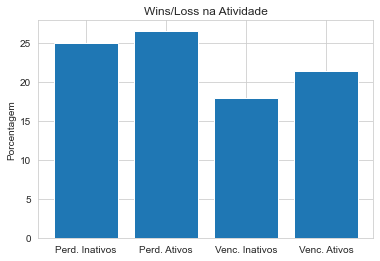

In [23]:
### Grafico do percentual acima
plot.bar(['Perd. Inativos','Perd. Ativos','Venc. Inativos','Venc. Ativos'],np.array([percent_perdedores,percent_perdedores_at,percent_vencedores,percent_vencedores_at])*100)
plot.title('Wins/Loss na Atividade')
plot.ylabel('Porcentagem')

In [24]:
### Percentual de jogadores bons ativos e inativos, relacionado com vitorias ou derrotas
bons_inativos_loss = bons_inativos[bons_inativos['saldo_pontos']<0]
percent_bons_inativos_loss = bons_inativos_loss.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0])
print(percent_bons_inativos_loss)

bons_inativos_wins = bons_inativos[bons_inativos['saldo_pontos']>0]
percent_bons_inativos_wins = bons_inativos_wins.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0])
print(percent_bons_inativos_wins)

bons_ativos_loss = bons_ativos[bons_ativos['saldo_pontos']<0]
percent_bons_ativos_loss = bons_ativos_loss.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0])
print(percent_bons_ativos_loss)

bons_ativos_wins = bons_ativos[bons_ativos['saldo_pontos']>0]
percent_bons_ativos_wins = bons_ativos_wins.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0]) 
print(percent_bons_ativos_wins)

0.07818930041152264
0.1168091168091168
0.0778727445394112
0.13327002215891104


Text(0, 0.5, 'Porcentagem')

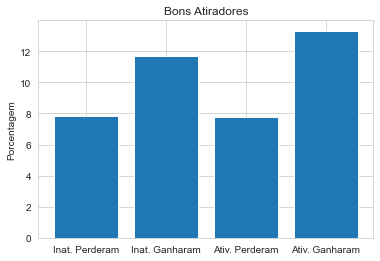

In [25]:
### Grafico do percentual acima
plot.bar(['Inat. Perderam','Inat. Ganharam','Ativ. Perderam','Ativ. Ganharam'],np.array([percent_bons_inativos_loss,percent_bons_inativos_wins,percent_bons_ativos_loss,percent_bons_ativos_wins])*100)
plot.title('Bons Atiradores')
plot.ylabel('Porcentagem')

In [26]:
### Porcentual de jogadores inativos 
inativos_mes.shape[0] / (inativos_mes.shape[0]+ativos_mes.shape[0]) *100

47.230136119025005

0.9835471735866549
0.9831588655376566


Text(0.5, 0, 'KDR')

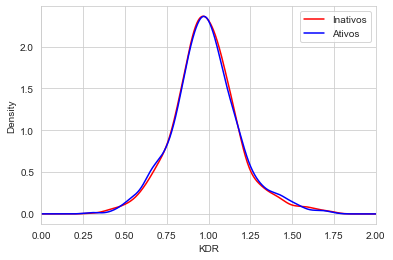

In [27]:
### Grafico de jogadores inativos e ativos por KDR
inativos_mes['kdr'].plot.kde(xlim=(0,2),color='r')
print(inativos_mes['kdr'].mean())
ativos_mes['kdr'].plot.kde(xlim=(0,2),color='b')
print(ativos_mes['kdr'].mean())
plot.legend(['Inativos', 'Ativos'])
plot.xlabel('KDR')

-0.8558981233243967
-0.3713257348530294


Text(0.5, 0, 'Saldo de Pontos')

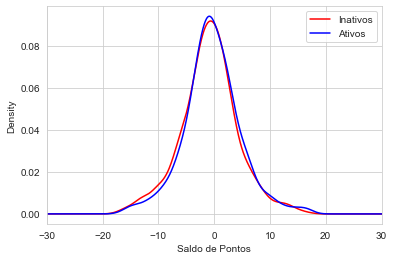

In [28]:
### Grafico de jogadores inativos e ativos por Saldo de Pontos
inativos_mes['saldo_pontos'].plot.kde(xlim=(-30,30),color='r')
print(inativos_mes['saldo_pontos'].mean())
ativos_mes['saldo_pontos'].plot.kde(xlim=(-30,30),color='b')
print(ativos_mes['saldo_pontos'].mean())
plot.legend(['Inativos', 'Ativos'])
plot.xlabel('Saldo de Pontos')

23.14276139410188
21.817036592681465


Text(0.5, 0, 'Partidas Jogadas')

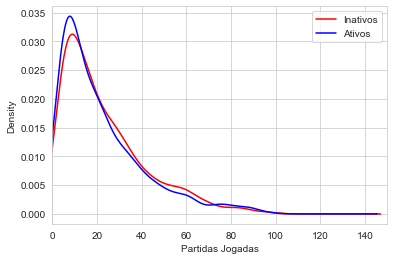

In [29]:
### Grafico de jogadores inativos e ativos por Partidas Jogadas
inativos_mes['matches_played'].plot.kde(xlim=(0,150),color='r')
print(inativos_mes['matches_played'].mean())
ativos_mes['matches_played'].plot.kde(xlim=(0,150),color='b')
print(ativos_mes['matches_played'].mean())
plot.legend(['Inativos', 'Ativos'])
plot.xlabel('Partidas Jogadas')

2013-05-12
2016-02-06
2018-11-02
2021-07-29


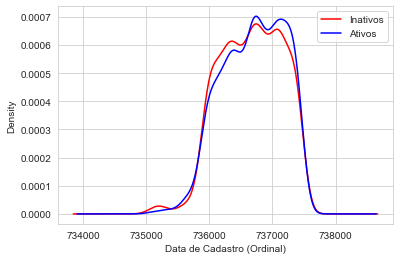

In [30]:
### Grafico de jogadores inativos e ativos por Data de Cadastro
actives_reg_date = pd.merge(ativos_mes, pl, on='player_id')
inactives_reg_date = pd.merge(inativos_mes, pl, on='player_id')

inactives_reg_date['cadastrado_em'] = [x.toordinal() for x in inactives_reg_date['cadastrado_em']]
inactives_reg_date['cadastrado_em'].plot.kde(color='r')

actives_reg_date['cadastrado_em'] = [x.toordinal() for x in actives_reg_date['cadastrado_em']]
actives_reg_date['cadastrado_em'].plot.kde(color='b')

plot.legend(['Inativos', 'Ativos'])
plot.xlabel('Data de Cadastro (Ordinal)')

### Legenda das datas
print(date.fromordinal(735000))
print(date.fromordinal(736000))
print(date.fromordinal(737000))
print(date.fromordinal(738000))